In [ ]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
pd.options.display.max_rows = 10

from shapely.ops import snap, unary_union
from shapely.geometry import Point, LineString, MultiLineString


In [ ]:
#brighton_points = gpd.read_file("../insight_project_dc/brighton/brighton_points.shp")
brighton_sidewalks = gpd.read_file("../insight_project_dc/brighton/brighton_sidewalks/brighton_sidewalks.shp")
EPSG_26919 = "EPSG:26919"

from shapely.ops import snap, unary_union
from shapely.geometry import Point, LineString, MultiLineString

def ls_to_mls(linestring):
    linelist = linestring.coords
    pairlist = list(zip(linelist, linelist[1:]))
    return MultiLineString(pairlist)
    

brighton_sidewalks['geometry'] = brighton_sidewalks.geometry.map(ls_to_mls)
brighton_sidewalks = brighton_sidewalks.explode().reset_index(drop=True)
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : len(x.coords)) != 2]

In [ ]:
def snap_endpoints(linestring, geom, tol):
    linelist = linestring.coords
    assert len(linelist) == 2
    p0 = snap(Point(linelist[0]), geom, tol)
    p1 = snap(Point(linelist[-1]), geom, tol)  
    #return LineString([Point(p0)] + list(map(Point, linelist[1:-1])) + [Point(pn)])
    return LineString([Point(p0), Point(p1)])
bright_sidewalks = brighton_sidewalks.to_crs(EPSG_26919)

In [ ]:
all_sidewalks = unary_union(pd.Series(brighton_sidewalks.geometry))
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : len(x.coords)) != 2]

In [ ]:
brighton_sidewalks.geometry = brighton_sidewalks.geometry.apply(lambda x: snap_endpoints(x, all_sidewalks, .5))
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : len(x.coords)) != 2]

In [ ]:
brighton_sidewalks.to_file("brighton_sidewalks_processed_26169.shp")

In [ ]:
import pickle as pkl
brighton_sidewalks = gpd.read_file("brighton_sidewalks_processed_26169.shp")
        
#all_sidewalks = unary_union(brighton_sidewalks.geometry)
#brighton_crosswalks.geometry = brighton_crosswalks.geometry.apply(lambda x: snap_endpoints(x, all_sidewalks, .5))
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : len(x.coords)) != 2]

In [ ]:
def round_pt(pt):
    a, b = pt
    a = round(a,1)
    b = round(b,1)
    return Point(a,b)

def round_edge(edge):
    a, b = tuple(edge.coords)
    a = round_pt(a)
    b = round_pt(b)
    return LineString([a,b])
    
brighton_sidewalks.geometry = brighton_sidewalks.geometry.map(round_edge)
brighton_sidewalks

In [ ]:
all_sidewalks =  unary_union(brighton_sidewalks.geometry)
sidewalks = brighton_sidewalks.geometry
all_sidewalks

In [ ]:
brighton_crosswalks.geometry = brighton_crosswalks.geometry.map(round_edge)


In [ ]:
from shapely.geometry import Point
points = list(map(Point, (list(set([point for ls in list(brighton_sidewalks.geometry.map(lambda x : list(x.coords)).values) for point in ls])))))
brighton_sw_points = gpd.GeoDataFrame(points)
brighton_sw_points.crs = EPSG_26919
brighton_sw_points.geometry = brighton_sw_points[0]
len_sw = len(list(brighton_sw_points.geometry.map(lambda x : x.coords)))
sw_coord_dict = dict(list(set(zip(list(brighton_sw_points.geometry.map(lambda x : tuple(x.coords)[0])), range(len_sw)))))
sw_coords = sw_coord_dict.keys()

In [ ]:
all_sw_points = unary_union(brighton_sw_points.geometry)

In [ ]:
# can't just use split because some crosswalks will be too short
# good news: every crosswalk is a single segment
# >> brighton_crosswalks[brighton_crosswalks.geometry.map(lambda x : len(x.coords)) != 2]
# for each segment:
## for each endpoint:
### find the nearest point on the sidewalks
### split the sidewalk at that point
## replace crosswalk with a segment between the new points
import shapely.ops as ops
from shapely.geometry import GeometryCollection


def fix_endpoint(endpt):
    return ops.nearest_points(endpt,all_sw_points)[1]
    

# named because sw segments get 'fixed' by fix_endpoint
def fix_cw_segment(seg):
    p0,p1 = seg.coords
    new_p0 = fix_endpoint(Point(p0))
    new_p1 = fix_endpoint(Point(p1))
    return(LineString([new_p0, new_p1]))

brighton_crosswalks.geometry = brighton_crosswalks.geometry.map(fix_cw_segment)

In [ ]:
def progressive_snap_to_sidewalks(pt, tol):
#    print("snapping")
    while True:
        snapped = snap(pt, all_sidewalks, tol)
        if snapped == pt:
            tol = tol * 1.1
#            print(tol)
        else:
            break
    assert snapped.touches(all_sidewalks), (snapped.distance(all_sidewalks), str(pt))
    return snapped
        
def snap_edge(edge, tol):
    p0,p1 = edge.coords
    new_p0 = progressive_snap_to_sidewalks(Point(p0), tol)
    new_p1 = progressive_snap_to_sidewalks(Point(p1), tol)
    return LineString([new_p0, new_p1])

In [ ]:
brighton_crosswalks.geometry = snapped_cw

In [ ]:
brighton_crosswalks.to_file("brighton_crosswalks_diditwork.shp")
brighton_sidewalks.to_file("brighton_sidewalks_diditwork.shp")

# IT WORKED

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
pd.options.display.max_rows = 10

from shapely.ops import snap, unary_union
from shapely.geometry import Point, LineString, MultiLineString


brighton_crosswalks = gpd.read_file("brighton_crosswalks_diditwork.shp")
brighton_sidewalks = gpd.read_file("brighton_sidewalks_diditwork.shp")




In [2]:
points = list(map(Point, (list(set([point for ls in list(brighton_sidewalks.geometry.map(lambda x : list(x.coords)).values) for point in ls])))))
brighton_sw_points = gpd.GeoDataFrame(points)
brighton_sw_points.geometry = brighton_sw_points[0]
len_sw = len(list(brighton_sw_points.geometry.map(lambda x : x.coords)))
sw_coord_dict = dict(list(set(zip(list(brighton_sw_points.geometry.map(lambda x : tuple(x.coords)[0])), range(len_sw)))))
sw_coords = sw_coord_dict.keys()


In [5]:
from shapely.coords import CoordinateSequence
brighton_sidewalks['u'] = brighton_sidewalks.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_sidewalks['v'] = brighton_sidewalks.geometry.map(lambda x : sw_coord_dict[x.coords[-1]])
brighton_sidewalks['key'] = 0

brighton_crosswalks['u'] = brighton_crosswalks.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_crosswalks['v'] = brighton_crosswalks.geometry.map(lambda x : sw_coord_dict[x.coords[-1]])
brighton_crosswalks['key'] = 1
brighton_sw_points['id'] = brighton_sw_points.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_sw_points['osmid'] = brighton_sw_points.id
brighton_crosswalks['osmid'] = brighton_crosswalks.index.map(lambda x : 10000 * x)
brighton_sidewalks['osmid'] = brighton_sidewalks.index.map(lambda x : 1000000000 * x)

In [6]:
brighton_sidewalks = brighton_sidewalks.to_crs("EPSG:4326")
brighton_crosswalks = brighton_crosswalks.to_crs("EPSG:4326")
brighton_sw_points.crs = "EPSG:26919"

brighton_sw_points = brighton_sw_points.to_crs("EPSG:4326")
brighton_sw_points['x'] = brighton_sw_points.geometry.map(lambda x : x.coords[0][1])
brighton_sw_points['y'] = brighton_sw_points.geometry.map(lambda x : x.coords[0][0])

In [7]:
brighton_sidewalks['length'] = brighton_sidewalks.length
brighton_crosswalks['length'] = brighton_crosswalks.length

In [40]:
def union_graph(points_gdfs, edges_gdfs, crs=None):
    points_df = pd.concat([pd.DataFrame(gdf) for gdf in points_gdfs], ignore_index=True, sort=False)
    edges_df = pd.concat([pd.DataFrame(gdf) for gdf in edges_gdfs], ignore_index=True, sort=False)
    
    if crs:
        points_gdf = gpd.GeoDataFrame(points_df, crs = points_gdfs[0].crs).to_crs(crs)
        edges_gdf = gpd.GeoDataFrame(edges_df, crs = edges_gdfs[0].crs).to_crs(crs)
    else:
        points_gdf = gpd.GeoDataFrame(points_df, crs = points_gdfs[0].crs)
        edges_gdf = gpd.GeoDataFrame(edges_df, crs = edges_gdfs[0].crs)
    return ox.utils_graph.graph_from_gdfs(points_gdf, edges_gdf)


brighton_G = union_graph([brighton_sw_points], [brighton_crosswalks, brighton_sidewalks])
brighton_G = ox.utils_graph.get_largest_component(brighton_G,strongly=True)

In [42]:
import pickle as pkl
with open("brighton_graph.pkl", 'wb') as pklfile:
    pkl.dump(brighton_G, pklfile)

In [37]:
import geocoder
g1 = geocoder.osm("34 Claymoss Rd, Boston, MA")
g2 = geocoder.osm("371 Washington St, Brighton, MA 02135")
g3 = geocoder.osm("90 monastery rd, Boston, MA")
p1 = Point(g1.json['lng'], g1.json['lat']).coords[0]
p2 = Point(g2.json['lng'], g2.json['lat']).coords[0]
p3 = Point(g3.json['lng'], g3.json['lat']).coords[0]
n1, d1 = ox.get_nearest_node(brighton_G, p1, method='haversine', return_dist=True)
n2, d2 = ox.get_nearest_node(brighton_G, p2, method='haversine', return_dist=True)
n3, d3 = ox.get_nearest_node(brighton_G, p3, method='haversine', return_dist=True)
p1, n1, d1, p2, n2, d2

((-71.14555578169282, 42.3441889),
 483,
 43.159379695352584,
 (-71.1540759, 42.3493367),
 2801,
 9.132937508625108)

In [38]:
import networkx as nx
route = nx.shortest_path(brighton_G, n1, n2)


In [39]:
ox.plot_route_folium(G, route)


In [25]:
gdf_edges = ox.graph_to_gdfs(G, nodes=False)

In [27]:
gdf_edges[(gdf_edges[''] == 4110)] #& (gdf_edges['v'] == 4110)]

,footway,forward,from,geometry,highway,key,layer,length,osmid,street_id,to,u,v
11707,NaN,1.0,4507,LINESTRING (-71.14567137170724 42.345517859304...,NaN,0,NaN,0.000307,3422000000000,149701299.0,4110,4507,4110
16911,NaN,1.0,4110,LINESTRING (-71.14587229470713 42.345750042578...,NaN,0,NaN,0.000328,3423000000000,149701299.0,6529,6529,4110


In [23]:
G=ox.utils_graph.get_largest_component(brighton_G.to_directed(),strongly=True)

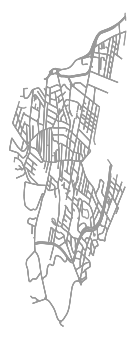

(<Figure size 496.077x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0a50b0a10>)

In [24]:
ox.plot_graph(G)

In [48]:
node_pd = ox.graph_to_gdfs(G, edges=False, nodes=True)

In [76]:
pts = list(map(lambda x : list(node_pd[node_pd['id'] == x].geometry.map(lambda x : x.coords[0]))[0] , route))

In [80]:
pd.DataFrame(pts).rename({0:'lat',1:'lng'},axis=1)

,lat,lng
0,42.345197,-71.145345
1,42.345407,-71.145569
2,42.345518,-71.145671
3,42.345528,-71.145651
4,42.345759,-71.145852
...,...,...
39,42.349100,-71.153443
40,42.349120,-71.154024
41,42.349128,-71.154181
42,42.349146,-71.154180
